# Проект по А/В тестированию

## Описание проекта

Есть датасет с действиями пользователей, техническое задание и несколько вспомогательных датасетов.

Цель:

дать оценку результатов A/B-теста 

Задачи:

* Оценить корректность проведения теста: пересечение тестовой аудитории с конкурирующим тестом,
совпадение теста и маркетинговых событий, другие проблемы временных границ теста.
* Проанализировать результаты теста

Техническое задание:

* Название теста: recommender_system_test;
* Группы: А (контрольная), B (новая платёжная воронка);
* Дата запуска: 2020-12-07;
* Дата остановки набора новых пользователей: 2020-12-21;
* Дата остановки: 2021-01-04;
* Аудитория: 15% новых пользователей из региона EU;
* Назначение теста: тестирование изменений, связанных с внедрением улучшенной рекомендательной системы;
* Ожидаемое количество участников теста: 6000.
* Ожидаемый эффект: за 14 дней с момента регистрации в системе пользователи покажут улучшение каждой метрики не менее, чем на 10%:
    * конверсии в просмотр карточек товаров — событие product_page
    * просмотры корзины — product_cart
    * покупки — purchase.

## Изучение данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from plotly import graph_objects as go
import seaborn as sns
import numpy as np
import math as mth
from scipy import stats as st
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.float_format', '{:,.2f}'.format)

In [2]:
marketing = pd.read_csv('/datasets/ab_project_marketing_events.csv')
marketing

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11
5,Black Friday Ads Campaign,"EU, CIS, APAC, N.America",2020-11-26,2020-12-01
6,Chinese New Year Promo,APAC,2020-01-25,2020-02-07
7,Labor day (May 1st) Ads Campaign,"EU, CIS, APAC",2020-05-01,2020-05-03
8,International Women's Day Promo,"EU, CIS, APAC",2020-03-08,2020-03-10
9,Victory Day CIS (May 9th) Event,CIS,2020-05-09,2020-05-11


In [3]:
marketing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       14 non-null     object
 1   regions    14 non-null     object
 2   start_dt   14 non-null     object
 3   finish_dt  14 non-null     object
dtypes: object(4)
memory usage: 576.0+ bytes


In [4]:
marketing.duplicated().sum()

0

Пропусков и дубликатов нет,требуется изменить тип данных в столбцах с датой

In [5]:
users = pd.read_csv('/datasets/final_ab_new_users.csv')
users.head()

,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone


In [6]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     61733 non-null  object
 1   first_date  61733 non-null  object
 2   region      61733 non-null  object
 3   device      61733 non-null  object
dtypes: object(4)
memory usage: 1.9+ MB


In [7]:
users.duplicated().sum()

0

Пропусков и дубликатов нет, требуется изменить тип данных в столбцах с датой

In [8]:
events = pd.read_csv('/datasets/final_ab_events.csv')
events.head()

,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99


In [9]:
events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     440317 non-null  object 
 1   event_dt    440317 non-null  object 
 2   event_name  440317 non-null  object 
 3   details     62740 non-null   float64
dtypes: float64(1), object(3)
memory usage: 13.4+ MB


In [10]:
events.duplicated().sum()

0

Пропуски есть в столбце details и дубликатов нет,требуется изменить тип данных в столбцах с датой

In [11]:
participants = pd.read_csv('/datasets/final_ab_participants.csv')
participants.head()

,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,482F14783456D21B,B,recommender_system_test


In [12]:
participants.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18268 entries, 0 to 18267
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  18268 non-null  object
 1   group    18268 non-null  object
 2   ab_test  18268 non-null  object
dtypes: object(3)
memory usage: 428.3+ KB


In [13]:
participants.duplicated().sum()

0

Пропусков и дубликатов нет

Посмотрим строчки в датафрейме events, где есть пропуски

In [14]:
events.groupby('event_name').agg({'details' : 'count'})

,details
event_name,
login,0
product_cart,0
product_page,0
purchase,62740


В колонке details датасета events хранятся только суммы покупок, число остальных событий равно числу пропусков. Пропуски в данном столбце никак не повлияют на результат. Можем их оставить

Поменяем типы данных

In [15]:
events['event_dt'] = pd.to_datetime(events['event_dt'])
users['first_date'] = pd.to_datetime(users['first_date'])
marketing['start_dt'] = pd.to_datetime(marketing['start_dt'])
marketing['finish_dt'] = pd.to_datetime(marketing['finish_dt'])

Данные готовы к дальнейшей работе

## Проверка корретности данных

Посмотрим количество участников каждого теста:

In [16]:
participants['ab_test'].value_counts()

interface_eu_test          11567
recommender_system_test     6701
Name: ab_test, dtype: int64

В данных представлены два теста. Нам по техническому заданию нужен recommender_system_test 

Посмотрим AB тест recommender_system_test

In [17]:
participants.query('ab_test == "recommender_system_test"').nunique()

user_id    6701
group         2
ab_test       1
dtype: int64

Уникальных пользователей 6701, группы две, тест один. 

Проверим есть ли участники, которые участвуют в двух тестах

In [18]:
two_users=participants.groupby('user_id').agg({'ab_test': 'nunique'}).reset_index().query('ab_test > 1')['user_id']
two_users.count()

1602

In [19]:
participants.groupby('user_id')['ab_test'].nunique()\
                      .reset_index().query('ab_test > 1').count()

user_id    1602
ab_test    1602
dtype: int64

Есть! И их 1602. Нахождение в двух тестах сразу искажает результаты дальнейшего анализа. Таких пользователей надо удалить

Оставляем только уникальных участников recommender_system_test

In [20]:
participants_clear = participants.query('ab_test == "recommender_system_test" and user_id not in @two_users')
participants_clear.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5099 entries, 0 to 6700
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  5099 non-null   object
 1   group    5099 non-null   object
 2   ab_test  5099 non-null   object
dtypes: object(3)
memory usage: 159.3+ KB


Проверили. что участники только в одном группе

In [21]:
participants_clear.groupby('user_id').agg({'group': 'count'}).query('group > 1')

,group
user_id,


Таких нет

Дальше рассматриваем только уникальных пользоватлей recommender_system_test

In [22]:
users_clear = pd.merge(participants_clear, users, on = 'user_id', how = 'left')
users_clear.sample(10)

,user_id,group,ab_test,first_date,region,device
1658,9745CE1D5B111CB1,A,recommender_system_test,2020-12-14,EU,iPhone
1971,97C81DBEC8A630F9,A,recommender_system_test,2020-12-20,EU,iPhone
4022,82AE150FE103247A,A,recommender_system_test,2020-12-20,EU,PC
306,D5677961ADDD8C4F,A,recommender_system_test,2020-12-07,EU,Android
2678,833B123682A99117,A,recommender_system_test,2020-12-07,EU,Android
4948,7898A26428D4BA04,B,recommender_system_test,2020-12-19,CIS,PC
3819,55AFFC54CA8EA71B,B,recommender_system_test,2020-12-13,EU,Android
43,2EE7F4150A02FF8E,A,recommender_system_test,2020-12-12,EU,PC
3410,958F3C157633225D,A,recommender_system_test,2020-12-19,EU,Android
1694,87A925B3240C69AB,B,recommender_system_test,2020-12-14,EU,iPhone


In [23]:
print(users_clear['first_date'].min().date(),users_clear['first_date'].max().date())

2020-12-07 2020-12-21


Участники регистрировались с 07.12 по 21.12, все согласно тех заданию

In [24]:
region = users_clear['region'].value_counts().reset_index()
region

,index,region
0,EU,4749
1,N.America,223
2,APAC,72
3,CIS,55


In [25]:
eu = len(users[users['region'] == 'EU']['user_id'].unique())
eu

46270

Общее количество пользователей из Европы 46270

In [26]:
eu_clear = users_clear[users_clear['region'] == 'EU']['user_id'].count()
eu_clear

4749

В нашем тесте пользователей из Европы 4749

In [27]:
((eu_clear/eu)*100).round(2)


10.26

Пользователей из региона EU: 10,26 %, что не соотвествуют тех заданию

Соединяем очищенную таблицу с участниками с событиями

In [28]:
events_clear = pd.merge(participants_clear, events, on = 'user_id', how = 'left')
events_clear.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21115 entries, 0 to 21114
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     21115 non-null  object        
 1   group       21115 non-null  object        
 2   ab_test     21115 non-null  object        
 3   event_dt    18804 non-null  datetime64[ns]
 4   event_name  18804 non-null  object        
 5   details     2483 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(4)
memory usage: 1.1+ MB


В объединенной таблице появились пропуски в столбцах, связанных с событием. Значит нет никакого события у данного пользователя. Можно удалить

In [29]:
events_clear = events_clear.dropna(subset = ['event_name'])
events_clear.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18804 entries, 0 to 21114
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     18804 non-null  object        
 1   group       18804 non-null  object        
 2   ab_test     18804 non-null  object        
 3   event_dt    18804 non-null  datetime64[ns]
 4   event_name  18804 non-null  object        
 5   details     2483 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(4)
memory usage: 1.0+ MB


Посмотрим время проведения теста

In [30]:
print(events_clear['event_dt'].min().date(), events_clear['event_dt'].max().date())

2020-12-07 2020-12-30


Дата остановки A/B тестирования 4 января 2021 года, однако исходя из полученной информации, мы видим, что последние событие было совершено 30 декабря 2020 года. Получается, что у нас отсутствуют данные за 5 дней или тест остановили заранее

Также для АВ теста выбрано не самое удачное время - время перед новым годом. В это время люди совершают много покупок и их поведение сильно отличается от обычного времени. Также в это время начинается пора скидок. 

Посмотрим какие маркетинговые активности совершались во время проведения теста

In [31]:
marketing.query('start_dt > "2020-12-07" and finish_dt < "2021-12-30"')

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
10,CIS New Year Gift Lottery,CIS,2020-12-30,2021-01-07


Действительно с 25.12 по 07.01 проходят 2 маркетинговых события, они могут повлиять на результаты, но так как регистрация участников закончилась 21.12 - это влияние не сильное

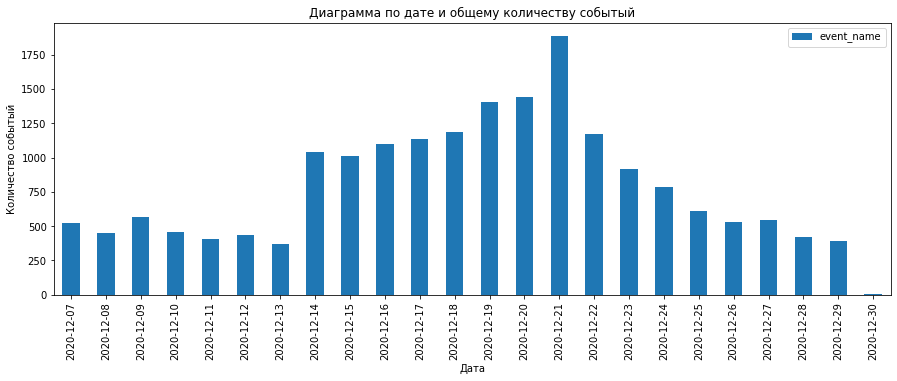

In [32]:
events_clear['date'] = pd.to_datetime(events_clear['event_dt']).dt.date
events_clear.groupby('date').agg({'event_name' : 'count'}).plot(kind= 'bar', figsize = (15, 5))
plt.xlabel("Дата")
plt.ylabel("Количество событый")
plt.title('Диаграмма по дате и общему количеству событый')
plt.show()

Посмотрим равномерность распределения по тестовым группам

In [33]:
events_clear.groupby('group').agg({'user_id': 'nunique'})

,user_id
group,
A,2082
B,706


Группы распределены неравномерно, это может сильно влиять на результат теста

## Исследовательский анализ

Количество событий на пользователя одинаково распределены в выборках?

In [34]:
event_by_user_id = events_clear.groupby(['user_id', 'group'])['event_name'].count().reset_index()

In [35]:
print('Среднее количество событий на пользователя в группе А: {:.0f}' \
                              .format(event_by_user_id.query('group == "A"')['event_name'].mean()))
print('Среднее количество событий на пользователя в группе B: {:.0f}' \
                                .format(event_by_user_id.query('group == "B"')['event_name'].mean()))

Среднее количество событий на пользователя в группе А: 7
Среднее количество событий на пользователя в группе B: 6


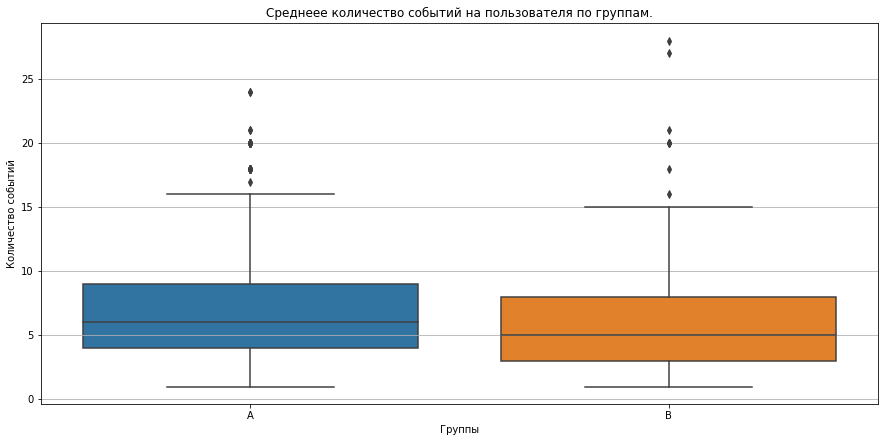

In [36]:
plt.figure(figsize = (15, 7))
plt.grid(True)
plt.title('Среднеее количество событий на пользователя по группам.')
sns.boxplot(data = event_by_user_id, y='event_name', x = 'group')
plt.ylabel('Количество событий')
plt.xlabel('Группы')
plt.show()

В группе А в среднем событий на пользователя больше.

Как число событий в выборках распределено по дням?

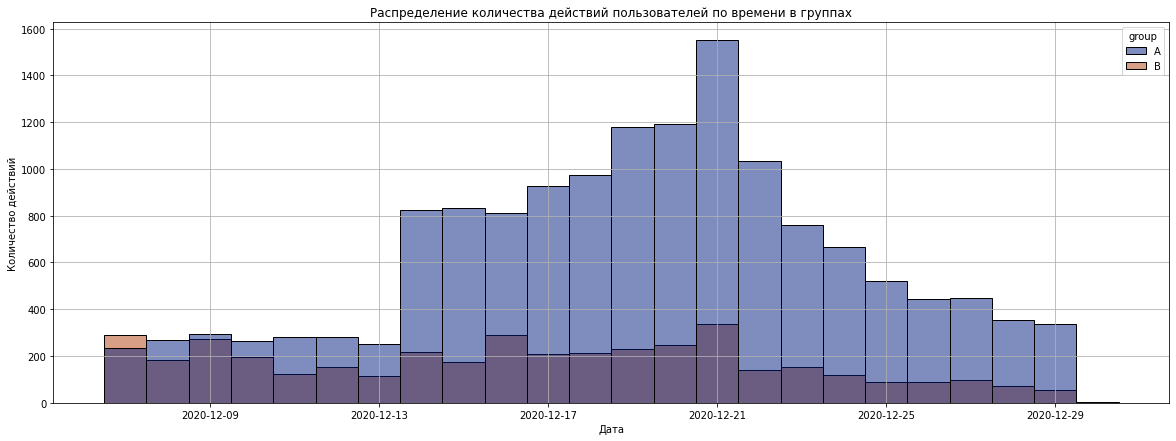

In [37]:
plt.figure(figsize = (20, 7))
plt.grid(True)
sns.histplot(data = events_clear, x = 'date', hue = 'group',palette='dark')
plt.title('Распределение количества действий пользователей по времени в группах')
plt.ylabel('Количество действий')
plt.xlabel('Дата')
plt.show()

По дням события распределены неравномерно. Мы видим увеличение действий перед праздниками с пиком совершенных событий 21.12.2020. Это последний день регистраций и возможно много людей регистрировались в последний момент

Как меняется конверсия в воронке в выборках на разных этапах?

In [38]:
funnel = events_clear.pivot_table(index = ('event_name'), values = 'user_id', aggfunc = {'user_id' : 'nunique'})\
                        .reset_index().sort_values('user_id', ascending = False)

funnel

,event_name,user_id
0,login,2788
2,product_page,1757
3,purchase,850
1,product_cart,826


In [58]:
fig = go.Figure(go.Funnel(
    y = funnel['event_name'].reindex([0,2,1,3]),
    x = funnel['user_id'].reindex([0,2,1,3]),
    textinfo = 'value+percent initial'

    ))
fig.update_layout(
    title = {
        'text' : 'Конверсия действий пользователей двух групп (A, B)',
        'x':0.5
    }
)
fig.show() 

По расчетам конверсии видно, что часть пользователей смогли купить (событие purchase) минуя просмотр корзины товаров (событие product_cart).

Посмотрим конверсию по группам

In [40]:
funnel_a = events_clear.query('group == "A"')\
                .groupby('event_name')['user_id'].nunique().reset_index().sort_values('user_id', ascending = False)
funnel_b = events_clear.query('group == "B"')\
                .groupby('event_name')['user_id'].nunique().reset_index().sort_values('user_id', ascending = False)

In [41]:
funnel_a

,event_name,user_id
0,login,2082
2,product_page,1360
3,purchase,652
1,product_cart,631


In [42]:
funnel_b

,event_name,user_id
0,login,706
2,product_page,397
3,purchase,198
1,product_cart,195


In [59]:
fig = go.Figure()

fig.add_trace(go.Funnel(
    name = 'A',
    y = funnel_a['event_name'].reindex([0,2,1,3]),
    x = funnel_a['user_id'].reindex([0,2,1,3]),
    textinfo = "value+percent previous"))

fig.add_trace(go.Funnel(
    name = 'B',
    y = funnel_b['event_name'].reindex([0,2,1,3]),
    x = funnel_b['user_id'].reindex([0,2,1,3]),
    textinfo = "value+percent previous"))

fig.update_layout(
    title = {
        'text' : 'Конверсия действий пользователей по группам (А, В)',
        'x':0.5
    }
)

fig.show()

По техническому заданию  результаты тестирования должны показать, что группа B на 10% лучше группы A. Но мы этого не видим. На этапе перехода от регистрации к покупке, группа B на 9% хуже группы A.На двух следующих этапах группа B на 1-2% лучше, чем группа A, однако этого недостаточно.Из группы A совершили покупку 31.3% пользователей. Из группы B покупку совершили 28% пользователей. Надо еще помнить, что выборки у нас разного размера.

## Оценка результатов А/В теста

Проверим статистическую разницу долей z-критерием

In [44]:
event_by_groups = events_clear\
                    .pivot_table(index = 'event_name', columns = 'group', values = 'user_id', aggfunc = 'nunique')\
                    .sort_values('A', ascending = False)
event_by_groups

group,A,B
event_name,,
login,2082,706
product_page,1360,397
purchase,652,198
product_cart,631,195


Формулируем гипотезы

*H0* : Для событий (product_page, purchase, product_cart), совершенных пользователями груп А и В нет статистической значимости в конверсии

*H1* :   Для событий (product_page, purchase, product_cart), совершенных пользователями груп А и В  статистическая значимость в конверсии есть

In [45]:
def z_test(group_1, group_2, eventname, alpha): 
    purchases1 = event_by_groups.loc[eventname, group_1]
    purchases2 = event_by_groups.loc[eventname, group_2]
    n1 = event_by_groups.iloc[0, 0]
    n2 = event_by_groups.iloc[0, 1]
    p1 = purchases1 / n1    
    p2 = purchases2 / n2     
    difference = p1 - p2    
    p_combined = (purchases1 + purchases2) / (n1 + n2)    
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1 / n1 + 1 / n2))                
    distr = st.norm(0, 1)    
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    
    print('Проверка события:', eventname)
    print('p-value: ',p_value)
   
    if (p_value < alpha):
        print("Отвергаем нулевую гипотезу: между конверсией групп есть значимая разница")
    else:
        print("Не получилось отвергнуть нулевую гипотезу, нет оснований считать конверсию групп разной") 
    print('')

In [46]:
for eventname in event_by_groups.index:
    z_test('A', 'B', eventname, 0.05)

Проверка события: login
p-value:  nan
Не получилось отвергнуть нулевую гипотезу, нет оснований считать конверсию групп разной

Проверка события: product_page
p-value:  1.5371909704686715e-05
Отвергаем нулевую гипотезу: между конверсией групп есть значимая разница

Проверка события: purchase
p-value:  0.10281767567786759
Не получилось отвергнуть нулевую гипотезу, нет оснований считать конверсию групп разной

Проверка события: product_cart
p-value:  0.1766337419130104
Не получилось отвергнуть нулевую гипотезу, нет оснований считать конверсию групп разной



Статистическая разница в долях между группами A и B есть только на этапе перехода на страницу товара. В остальных случаях статистически значимой разницы между долями групп A и B нет. 

## Выводы

В ходе исследования мы можем с уверенностью сказать, что проведенный А/В тест некорректный и не соответсвует техническому заданию. Заявленных участников меньше 6000, процент заявленных участников из Европы не соответствует заданию. тест должен был проводиться до 04.01.2022, но мы имеем данные только до 30.12.2021. Либо данные не предоставлены, либо тест остановили раньше времени.

Также одновременно проходил еще один тест. А время проведения выпало на предновогодние дни, новогодние и рождественнские праздники, в которых проводились маркетинговые события, что могло повлиять на активность участников.

Распределение по группам тоже неравномерное, в группе В участников меньше больше, чем на половину группы А.

Нарушена логическая последовательность событий: часть пользователей смогли купить минуя просмотр корзины товаров

Ожидаемый эффект, что за 14 дней с момента регистрации в системе пользователи покажут улучшение каждой метрики не менее, чем на 10%, не случился. Конверсия события product_page у группы А на 9% больше, чем у группы В.Конверсия события product_cart у группы А на 1% меньше, чем у группы В.Конверсия события purchase у группы А на 2% меньше, чем у группы В.Статистическая разница в долях между группами A и B есть только на этапе перехода на страницу товара.

Для удачного А/В теста необходимо больше уникальных пользователями, равномерно разделить на группы, исключить одновременного проведения других тестов и маркетинговых событий.